In [362]:
# Import packages
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Data Preparation

In [99]:
# Read multiple zip files and combine into a dataframe
ls = []
for files in glob.glob(os.getenv("PUIDATA") + "/NYCBusiness/*.zip"):
    zf = zipfile.ZipFile(files)
    df = pd.read_csv(zf.open(files[-15:].replace('.zip','.txt')))
    if any(df.columns == 'est'):
        df = df[['zip', 'est']]
    elif any(df.columns == 'EST'):
        df = df[['ZIP', 'EST']]
        df.rename(columns={'ZIP': 'zip', 'EST': 'est'}, inplace=True)
    else:
        print 'wrong column name'
    df.rename(columns={'est': files[-12:-10]}, inplace=True)
    ls.append(df)
df_final = reduce(lambda left,right: pd.merge(left,right,on='zip', how='outer'), ls)

In [152]:
# Rearrange the dataframe in temporal order
df_final = df_final[['zip', 
          '94', '95', '96', '97', '98', '99', 
          '00', '01', '02', '03', '04', '05', '06', 
          '07', '08', '09', '10', '11', '12', '13', '14']]

In [109]:
# Load NYC zip geojson file
zip_nyc_path = os.getenv("PUIDATA") + "/NYCzip_shape/nyc-zip-code-tabulation-areas-polygons.geojson"
zip_nyc = gpd.read_file(zip_nyc_path)

In [154]:
# Subset df_final with only NYC zipcodes
df_nyc = df_final.loc[df_final['zip'].isin(np.int64(zip_nyc.postalCode))]

In [158]:
df_nyc.head()

,zip,94,95,96,97,98,99,00,01,02,...,05,06,07,08,09,10,11,12,13,14
2966,10001.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
2967,10002.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
2968,10003.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
2969,10004.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
2970,10005.0,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [164]:
# Clean data. drop time series with more than 5 null values, and fill the rest null value with 0.
df_nyc.set_index('zip', inplace=True)
df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 0]
df_nyc = df_nyc.drop(df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 5].index)
df_nyc.fillna(0, inplace=True)

In [186]:
# Standardize time series by subtracting each row's mean and divided by each row standard, respectively.
df_nyc = df_nyc.subtract(df_nyc.mean(axis=1), axis=0)
df_nyc = df_nyc.divide(df_nyc.std(axis=1), axis=0)

In [197]:
# Check the dimension of the standardized dataframe
df_nyc.shape

(236, 21)

# KMeans Clustering

In [208]:
# Use Silhouette Score to estimate the number of clusters for Kmeans clustering.
range_n_clusters = range(3,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = km.fit_predict(df_nyc)
    silhouette_avg = silhouette_score(df_nyc, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters = 3, the average silhouette_score is :0.514389546988
For n_clusters = 4, the average silhouette_score is :0.489353539024
For n_clusters = 5, the average silhouette_score is :0.351285617663
For n_clusters = 6, the average silhouette_score is :0.243034269957
For n_clusters = 7, the average silhouette_score is :0.244360078699
For n_clusters = 8, the average silhouette_score is :0.156138139108
For n_clusters = 9, the average silhouette_score is :0.156950063235


In [261]:
# Get the result of kmeans clustering with 4 clusters
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=123)
km_labels = km.fit_predict(df_nyc)

In [263]:
# Double-check the shape of the cluster centers
km.cluster_centers_.shape

(4, 21)

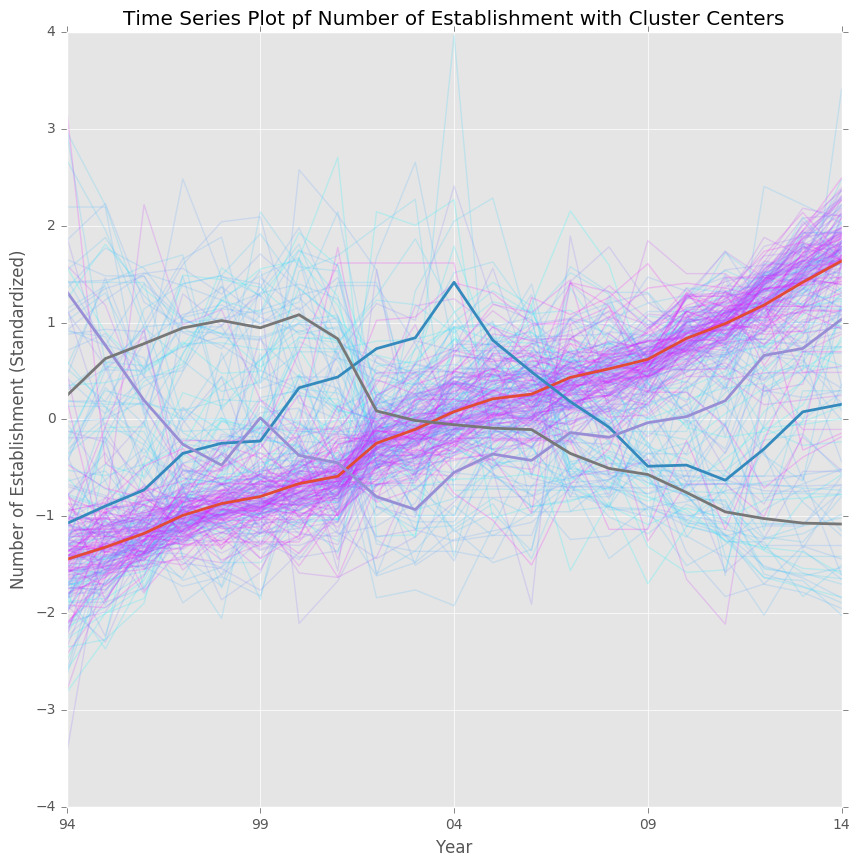

In [266]:
# Plot the KMeans clustering results with cluster center time series
ax = df_nyc.T.plot(figsize=(10,10), legend=False, c=cluster_labels, cmap=plt.cm.cool, alpha=0.2)
plt.plot(km.cluster_centers_.T, linewidth=2)
plt.xlabel('Year')
plt.ylabel('Number of Establishment (Standardized)')
plt.title('Time Series Plot pf Number of Establishment with Cluster Centers')
plt.show()

# Feature Agglomeration Clustering

In [329]:
# Feature Agglomeration Clustering with 4 clusters
fa = FeatureAgglomeration(n_clusters=4)
fa_labels = fa.fit(df_nyc.T).labels_

In [330]:
# Combine two clustering results into the geopandas dataframe
label_nyc = pd.DataFrame({'zip': df_nyc.index, 'kmeans': cluster_labels, 'featureagglomeration': fa_labels})
label_nyc['zip'] = label_nyc['zip'].astype(int).astype('str')
cluster_nyc = pd.merge(label_nyc, zip_nyc, left_on='zip', right_on='postalCode', how='outer')
cluster_nyc = gpd.GeoDataFrame(cluster_nyc)

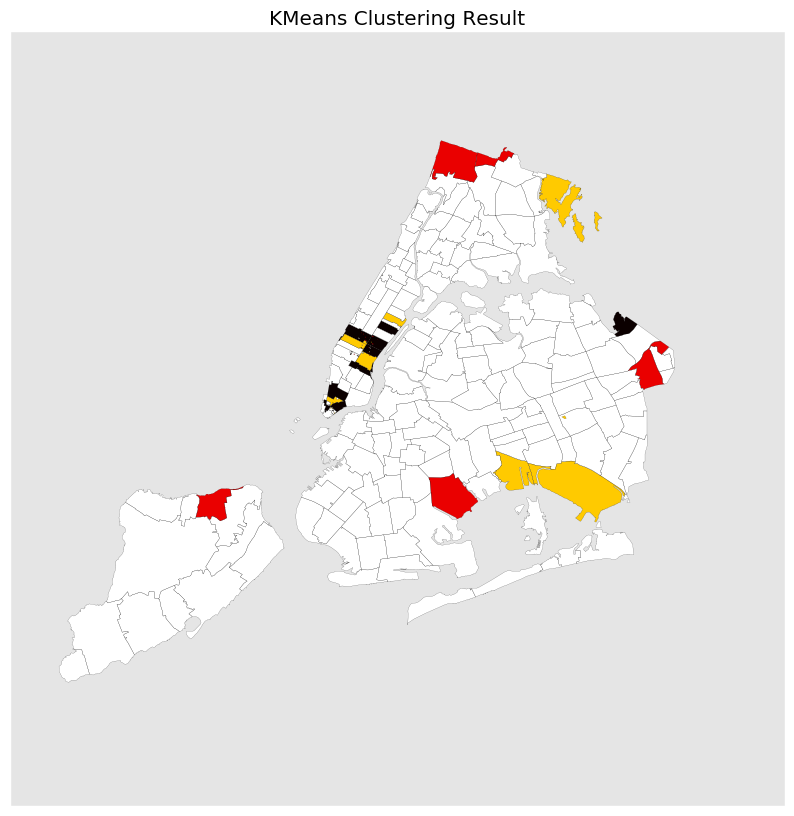

In [359]:
# Map KMeans clustering result
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_nyc.plot(column='kmeans', colormap='hot_r',alpha=1,linewidth=0.1, ax=ax)
plt.title('KMeans Clustering Result')
plt.show()

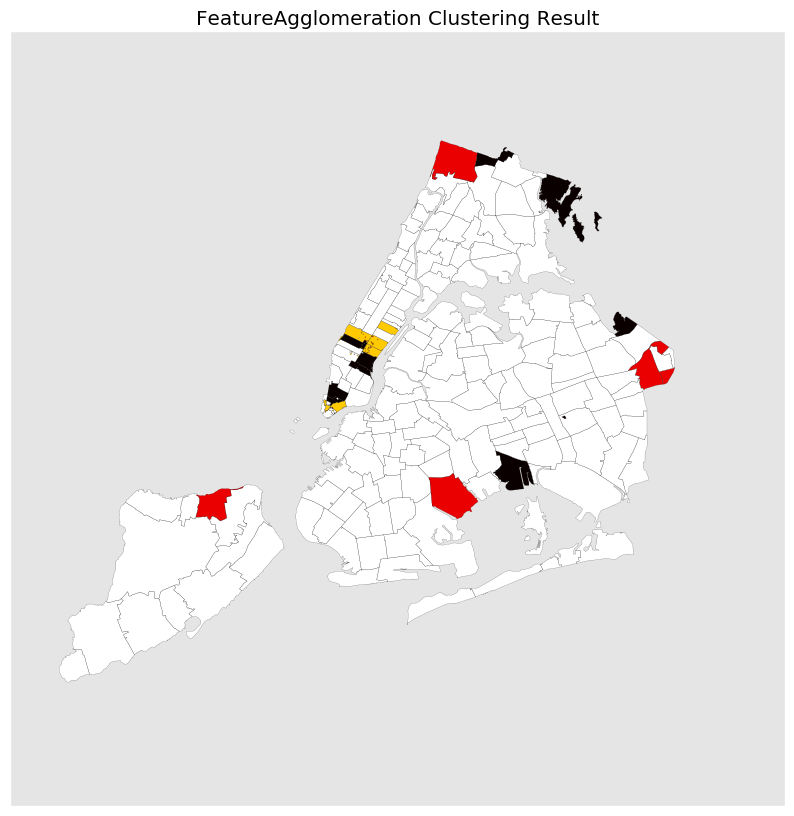

In [361]:
# Map Feature bAgglomeration clustering result
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_nyc.plot(column='featureagglomeration', colormap='hot_r',alpha=1,linewidth=0.1, ax=ax)
plt.title('FeatureAgglomeration Clustering Result')
plt.show()

Comparing both clustering methods results, it is found that both results are quite similar. By looking at Google Maps it seems the red regions are either closed to or are park areas.

In [ ]:
#@Review: insufficient comments
#6. Compare the results of the 2 algorithms
#7. attempt an interpretation.